In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


pd.set_option('display.max_rows', 50)

In [2]:
!ls ../data/nhanes_all/

ls: ../data/nhanes_all/: No such file or directory


In [3]:
# Load
dem = pd.read_csv('../data/nhanes_1994-2018/demographics_clean.csv', index_col=0)
dem = dem[['RIDAGEYR', 'RIAGENDR', 'SEQN', 'SEQN_new']]

# add chemistry
chem = pd.read_csv('../data/nhanes_1994-2018/chemicals_clean.csv', index_col=0)
# LBXSCR = Serum creatinine (mg/dL)'
#
df = dem.merge(chem, how = 'inner', on = ['SEQN', 'SEQN_new'])

# add body measures
response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)
# response = response[['BMXWT', 'BMXHT', 'BMXBMI', 'BMXWAIST', 'SEQN', 'SEQN_new', 'SPPFEV05', 'SPXNFVC',
#                      'BPXSAR', 'LBXSBU', 'LBDHDD', 'LBXSCR', 'LBDSALSI', 'LBXCRP']]
"""
CANDIDATES 

BMXWT # Weight (kg)
BMXHT # Standing Height (cm)
BMXBMI # Body Mass Index (kg/m**2)
BMXWAIST # Waist Circumference (cm)
SPPFEV05 # Forced expiratory volume (mL)
SPXNFVC # Baseline 1st Test Spirometry, Forced Vital Capacity, in mL.
VNAVEBPXSY = Systolic: Average blood pressure (mm Hg)
LBXSCR = Serum creatinine (mg/dL)'
LBXSBU = Serum blood urea nitrogen (mg/dL)
LBDHDD = Serum HDL cholesterol (mg/dL)
LBDSALSI	Serum albumin: SI (g/L)
LBXCRP	Serum C-reactive protein (mg/dL)
"""
df = df.merge(response, how = 'inner', on = ['SEQN', 'SEQN_new'])

# Remove data with too many nans
# df = df[df.columns[df.isna().sum()<70000]]

# Rename columns
dictionary_nhanes = pd.read_csv('../data/nhanes_1994-2018/dictionary_nhanes.csv',index_col=0)
dictionary_nhanes[['variable_codename_use', 'variable_description_use']]
mapping_dict = dict(zip(dictionary_nhanes['variable_codename_use'], dictionary_nhanes['variable_description_use']))
del mapping_dict['SEQN']                     
del mapping_dict['SEQN_new']                     
mapping_dict['RIDAGEYR'] = 'age'
mapping_dict['RIAGENDR'] = 'gender'

df = df.rename(columns=mapping_dict)
df

/var/folders/fh/jpzybjhs0nq0265pm39s6kf80000gn/T/ipykernel_35588/219444611.py:12: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


,age,gender,SEQN,SEQN_new,SDDSRVYR_x,Serum selenium replicate 2 (ug/L),total Lycopene replicate 1 (ug/dL),total Lycopene replicate 2 (ug/dL),Serum alpha carotene replicate 1 (ug/dL),Serum alpha carotene replicate 2 (ug/dL),...,Serum transferrin receptor (mg/L),Serum uric acid: SI (umol/L),Serum uric acid: SI replicate 1 (umol/L),Serum uric acid: SI replicate 2 (umol/L),Serum uric acid (mg/dL),Serum uric acid replicate 1 (mg/dL),Serum uric acid replicate 2 (mg/dL),N-telopeptides (NTx) (nmol BCE),N-telopeptides (NTx) replicate 1 (nmol BCE),N-telopeptides (NTx) replicate 2 (nmol BCE)
0,21,1,3.0,I-3,-1,NaN,65.0,NaN,5.0,NaN,...,NaN,327.1,327.1,NaN,5.50,5.5,NaN,NaN,NaN,NaN
1,32,2,4.0,I-4,-1,NaN,16.0,NaN,7.0,NaN,...,NaN,166.5,166.5,NaN,2.80,2.8,NaN,NaN,NaN,NaN
2,48,2,9.0,I-9,-1,106.0,18.0,15.0,4.0,4.0,...,NaN,306.3,297.4,315.2,5.15,5.0,5.3,NaN,NaN,NaN
3,35,1,10.0,I-10,-1,NaN,17.0,NaN,5.0,NaN,...,NaN,380.7,380.7,NaN,6.40,6.4,NaN,NaN,NaN,NaN
4,48,1,11.0,I-11,-1,NaN,30.0,NaN,6.0,NaN,...,NaN,249.8,249.8,NaN,4.20,4.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121740,70,2,102952.0,C-102952,10,NaN,NaN,NaN,NaN,NaN,...,2.47,380.7,NaN,NaN,6.40,NaN,NaN,NaN,NaN,NaN
121741,42,1,102953.0,C-102953,10,NaN,NaN,NaN,NaN,NaN,...,2.42,345.0,NaN,NaN,5.80,NaN,NaN,NaN,NaN,NaN
121742,41,2,102954.0,C-102954,10,NaN,NaN,NaN,NaN,NaN,...,21.00,184.4,NaN,NaN,3.10,NaN,NaN,NaN,NaN,NaN
121743,14,2,102955.0,C-102955,10,NaN,NaN,NaN,NaN,NaN,...,4.89,374.7,NaN,NaN,6.30,NaN,NaN,NaN,NaN,NaN


In [4]:
df

,age,gender,SEQN,SEQN_new,SDDSRVYR_x,Serum selenium replicate 2 (ug/L),total Lycopene replicate 1 (ug/dL),total Lycopene replicate 2 (ug/dL),Serum alpha carotene replicate 1 (ug/dL),Serum alpha carotene replicate 2 (ug/dL),...,Serum transferrin receptor (mg/L),Serum uric acid: SI (umol/L),Serum uric acid: SI replicate 1 (umol/L),Serum uric acid: SI replicate 2 (umol/L),Serum uric acid (mg/dL),Serum uric acid replicate 1 (mg/dL),Serum uric acid replicate 2 (mg/dL),N-telopeptides (NTx) (nmol BCE),N-telopeptides (NTx) replicate 1 (nmol BCE),N-telopeptides (NTx) replicate 2 (nmol BCE)
0,21,1,3.0,I-3,-1,NaN,65.0,NaN,5.0,NaN,...,NaN,327.1,327.1,NaN,5.50,5.5,NaN,NaN,NaN,NaN
1,32,2,4.0,I-4,-1,NaN,16.0,NaN,7.0,NaN,...,NaN,166.5,166.5,NaN,2.80,2.8,NaN,NaN,NaN,NaN
2,48,2,9.0,I-9,-1,106.0,18.0,15.0,4.0,4.0,...,NaN,306.3,297.4,315.2,5.15,5.0,5.3,NaN,NaN,NaN
3,35,1,10.0,I-10,-1,NaN,17.0,NaN,5.0,NaN,...,NaN,380.7,380.7,NaN,6.40,6.4,NaN,NaN,NaN,NaN
4,48,1,11.0,I-11,-1,NaN,30.0,NaN,6.0,NaN,...,NaN,249.8,249.8,NaN,4.20,4.2,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121740,70,2,102952.0,C-102952,10,NaN,NaN,NaN,NaN,NaN,...,2.47,380.7,NaN,NaN,6.40,NaN,NaN,NaN,NaN,NaN
121741,42,1,102953.0,C-102953,10,NaN,NaN,NaN,NaN,NaN,...,2.42,345.0,NaN,NaN,5.80,NaN,NaN,NaN,NaN,NaN
121742,41,2,102954.0,C-102954,10,NaN,NaN,NaN,NaN,NaN,...,21.00,184.4,NaN,NaN,3.10,NaN,NaN,NaN,NaN,NaN
121743,14,2,102955.0,C-102955,10,NaN,NaN,NaN,NaN,NaN,...,4.89,374.7,NaN,NaN,6.30,NaN,NaN,NaN,NaN,NaN


In [5]:
# Load from ../data responses   


In [15]:

def test_features_for_age_prediction(df):
    results = pd.DataFrame(columns=['Feature', 'R-squared', 'Non-Null Values', 'Unique Ages Amount', 'Note'])
    
    for feature in tqdm(df.columns):
        if feature in ['age', 'SEQN', 'SEQN_new']: 
            continue
            
        try:
            X = df[[feature, 'age']].dropna()
            X_feature = X[[feature]].copy()  # Create a copy to apply transformations if needed
            
            if 'replicate' in feature: 
                continue

            else:
                note = ""
                
            y = X['age']
            unique_ages_amount = len(set(y))
            
            if unique_ages_amount < 60:
                note += "; Too few unique ages" if note else "Too few unique ages"
                
            if len(y) < 9000:
                note += "; Not enough data" if note else "Not enough data"
                
            # model = LinearRegression()
            model = CatBoostRegressor(max_depth=3, iterations=100, verbose=False)
            model.fit(X_feature, y)
            y_pred = model.predict(X_feature)
            r2 = r2_score(y, y_pred)
            
            feature_results = pd.DataFrame({
                'Feature': [feature],
                'R-squared': [r2],
                'Non-Null Values': [X.shape[0]],
                'Unique Ages Amount': [unique_ages_amount],
                'Note': [note]
            })
            results = pd.concat([results, feature_results], ignore_index=True)
        except Exception as e:
            print(f"Error processing {feature}: {e}")  # Optional: handle or log exceptions
            
    results = results.sort_values(by='R-squared', ascending=False, ignore_index=True)
    return results


results = test_features_for_age_prediction(df)
results.to_csv('data/1factor_analysis.csv')

  0%|          | 0/1625 [00:00<?, ?it/s]

/var/folders/fh/jpzybjhs0nq0265pm39s6kf80000gn/T/ipykernel_35588/2990377448.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, feature_results], ignore_index=True)


Error processing Atrazine (ug/L): /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
Error processing Di-cresyl phosphates (ug/L): /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
Error processing Urinary 9-chlorohexadecafluoro-3-oxanonane-1-sulfonate (ng/mL): /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
Error processing Urinary Adona (ammonium salt of 4,8-dioxa-3H-perfluorononanoate) (ng/mL): /Users/zomb-ml-platform-msk/go-agent-21.2.0/pipelines/BuildMaster/catboost.git/catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.
Error processing Urinary Perfluoropentanoic acid (ng/mL): /Users/zomb-ml-platform-ms

In [16]:
results.to_csv('data/1factor_analysis.csv')


In [17]:
import os
import matplotlib.pyplot as plt

# Ensure the 'data/plots' directory exists
plot_dir = "data/plots"
os.makedirs(plot_dir, exist_ok=True)

# Sorting the results by 'R-squared' in descending order, if not already sorted
results = results.sort_values('R-squared', ascending=False)

features = results['Feature'].unique()
grouped_df = df.groupby('age')[features].mean()

for ind, row in results[results['R-squared'] > 0].iterrows():
    feature = row['Feature']
    r2_score = row['R-squared']
    
    if feature in grouped_df.columns:
        plt.figure(figsize=(5, 4))  # Adjust the figure size as necessary
        plt.plot(grouped_df.index, grouped_df[feature], label=f'{feature} (R2={r2_score:.2f})')
        plt.xlabel('Age')
        plt.ylabel('Mean ' + feature)
        plt.title(f'Feature: {feature} vs Age')
        plt.legend()

        # Sanitize the feature name for the filename (remove colons, replace spaces with underscores)
        safe_feature_name = feature.replace(':', '').replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        safe_feature_name = safe_feature_name[:150]
        
        # Construct the filename, now with the sanitized feature name
        filename = os.path.join(plot_dir, f"rank_{ind+1}_R2_{r2_score:.2f}_{safe_feature_name}.png")

        plt.savefig(filename)
        plt.close()
    else:
        print(feature)


In [121]:
safe_feature_name[:150]

'Bronchodilator_2nd_Test_Spirometry,_Forced_Expiratory_Time_seconds'

In [113]:
features.shape

(978,)

In [111]:
grouped_df.columns

Index(['Predicted maximal heart rate (per minute)', 'PCB209 (ng/g)',
       'Recumbent Length (cm)', 'PCB209 Lipid Adj (ng/g)',
       'PCB196 & 203 (ng/g)', 'PCB138 & 158 (ng/g)', 'PCB180 (ng/g)',
       'Oxychlordane (ng/g)', 'PCB196 (ng/g)', 'Trans-nonachlor (ng/g)',
       ...
       'Arm selected for blood pressure monitoring',
       'Di-o-cresyl phosphate (ug/L)',
       'Reason for Priority 2 Stop: Heart rate exceeds predetermined limit during stage 1',
       'Reason for Priority 2 Stop: Sudden, noticeable variability in heart rate (sudden change of more than 30 beats/minute during a stage)',
       'Reason for Priority 2 Stop: Other specified reasons',
       'Reason for Priority 2 Stop: Significant drop (> 20 mm Hg) in systolic blood pressure during exercise',
       'Reason for Priority 2 Stop: Participant is unable to stop gripping hand rails',
       'Di-cresyl phosphates (ug/L)',
       'Amputations: Lower Left. Above or Below Knee?',
       'Unusual value noted during d

In [50]:
os.environ["ANTHROPIC_API_KEY"] = ""

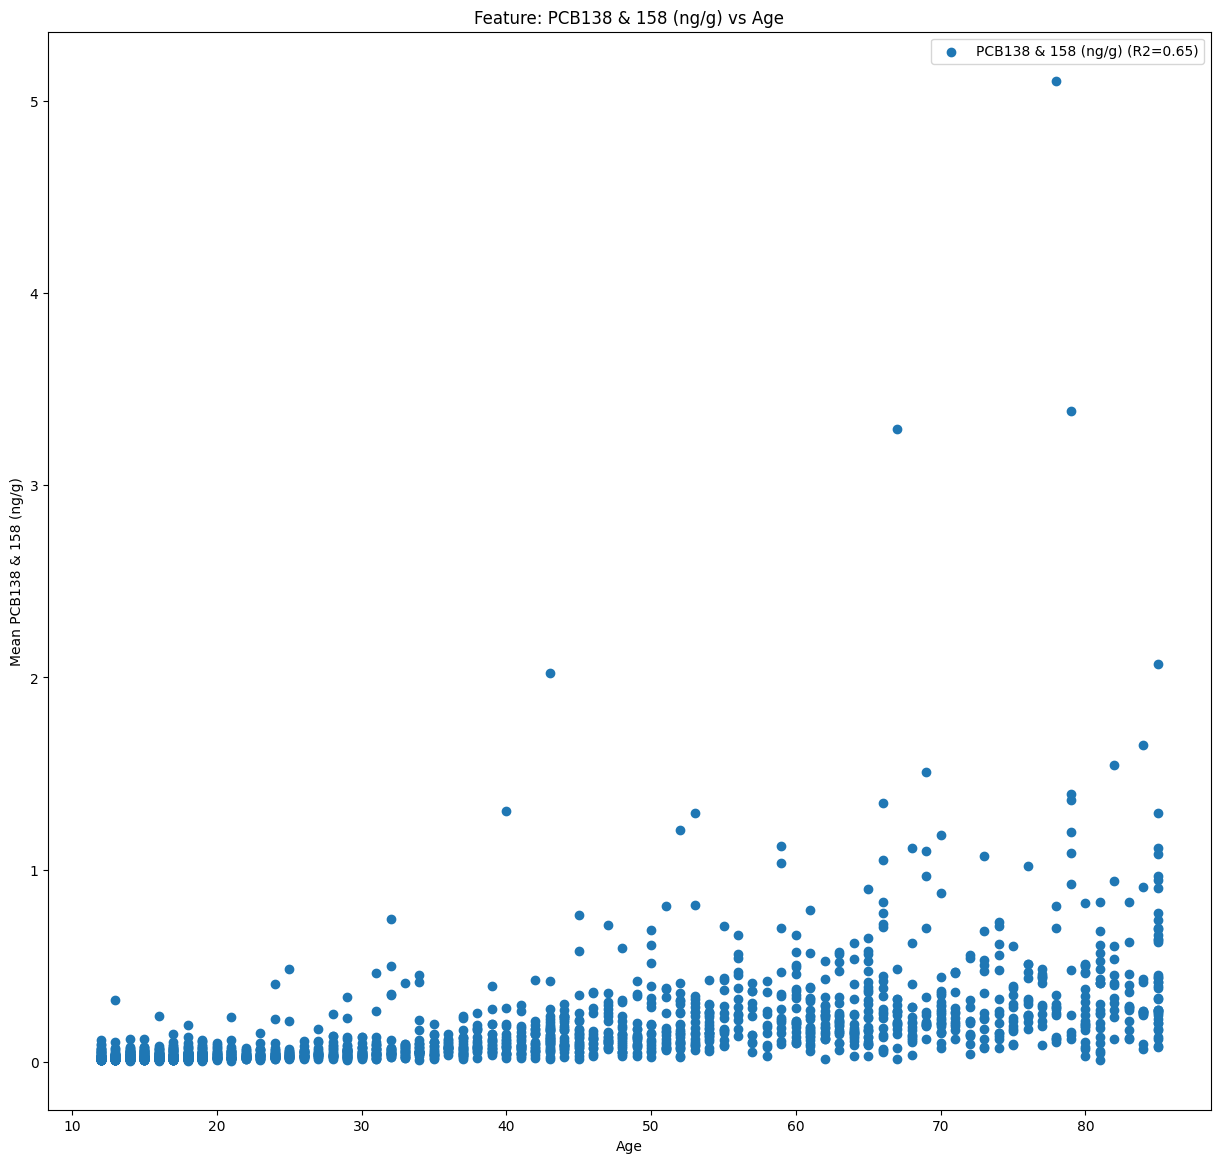

In [105]:
plt.figure(figsize=(15, 14))  # Adjust the figure size as necessary
plt.scatter(df['age'], df[feature], label=f'{feature} (R2={r2_score:.2f})')
plt.xlabel('Age')
plt.ylabel('Mean ' + feature)
plt.title(f'Feature: {feature} vs Age')
plt.legend()


In [99]:
# for ind, row in tqdm(results[results['R-squared'] > 0.1].iterrows()):

row = results.loc[0]

safe_feature_name = feature.replace(':', '').replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
filename = os.path.join(plot_dir, f"rank_{ind+1}_R2_{r2_score:.2f}_{safe_feature_name}.png")
plt.savefig(filename)
plt.close()

# Decision-making process
data_dec = row.to_dict()
prompt = f'''You are provided with results of an experiment by training linear regression to predict chronological age with only 1 feature. 
Conclude whether this feature should go to the final set of features to train a model to predict age. 
The main purpose of this model is to track the improvements of health after changing lifestyle. Return "Yes" or "No".
Output format in json with 2 keys "conclusion" and "confidence"

Results:
{data_dec}
'''
# Get the decision and confidence from the Anthropic API
conclusion, confidence = get_antropic_answer(prompt, feature)


feature: PCB138 & 158 (ng/g),  No, Confidence: 0.95


In [101]:
pprint(prompt)

('You are provided with results of an experiment by training linear regression '
 'to predict chronological age with only 1 feature. \n'
 'Conclude whether this feature should go to the final set of features to '
 'train a model to predict age. \n'
 'The main purpose of this model is to track the improvements of health after '
 'changing lifestyle. Return "Yes" or "No".\n'
 'Output format in json with 2 keys "conclusion" and "confidence"\n'
 '\n'
 'Results:\n'
 "{'Feature': 'Predicted maximal heart rate (per minute)', 'R-squared': "
 "0.9999983626063781, 'Non-Null Values': 14417, 'Unique Ages Amount': 38, "
 "'Note': 'Too few unique ages'}\n")


In [97]:
import ast
import anthropic
import os
import matplotlib.pyplot as plt
import pandas as pd  # Assuming pandas is used

# Assuming 'results' and 'df' are pre-defined DataFrame objects
# Ensure the 'data/plots' directory exists
plot_dir = "data/plots"
os.makedirs(plot_dir, exist_ok=True)

# Sorting the results by 'R-squared' in descending order
results = results.sort_values('R-squared', ascending=False)

features = results['Feature'].unique()
grouped_df = df.groupby('age')[features].mean()

def get_antropic_answer(prompt, feature=None):
    client = anthropic.Anthropic(api_key=os.environ.get("ANTHROPIC_API_KEY"))
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=100,
        temperature=0,
        system="you are a python machine learning code assistant",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ]
    )

    # Assuming the message.content structure, adjust based on actual API response
    conclusion = ast.literal_eval(message.content[0].text)['conclusion']
    confidence = ast.literal_eval(message.content[0].text)['confidence']
    print(f"feature: {feature},  {conclusion}, Confidence: {confidence}")
    return conclusion, confidence


confidences = []
decisions = []
for ind, row in tqdm(results[results['R-squared'] > 0.1].iterrows()):
    feature = row['Feature']
    r2_score = row['R-squared']
    
    if feature in grouped_df.columns:
        plt.figure(figsize=(5, 4))  # Adjust the figure size as necessary
        plt.plot(grouped_df.index, grouped_df[feature], label=f'{feature} (R2={r2_score:.2f})')
        plt.xlabel('Age')
        plt.ylabel('Mean ' + feature)
        plt.title(f'Feature: {feature} vs Age')
        plt.legend()
        
        # Sanitize the feature name for the filename
        safe_feature_name = feature.replace(':', '').replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')
        filename = os.path.join(plot_dir, f"rank_{ind+1}_R2_{r2_score:.2f}_{safe_feature_name}.png")
        plt.savefig(filename)
        plt.close()

        # Decision-making process
        data_dec = row.to_dict()
        prompt = f'''You are provided with results of an experiment by training linear regression to predict chronological age with only 1 feature. 
Conclude whether this feature should go to the final set of features to train a model to predict age. 
The main purpose of this model is to track the improvements of health after changing lifestyle. Return "Yes" or "No".
Output format in json with 2 keys "conclusion" and "confidence"

Results:
{data_dec}
'''
        # Get the decision and confidence from the Anthropic API
        conclusion, confidence = get_antropic_answer(prompt, feature)

        # Append the conclusion and confidence to the lists
        decisions.append(conclusion)
        confidences.append(confidence)


results_filtered = results[results['R-squared'] > 0.1].copy() # Filter the results as per the loop condition
results_filtered['Decision'] = decisions
results_filtered['Confidence'] = confidences

0it [00:00, ?it/s]

feature: Predicted maximal heart rate (per minute),  No, Confidence: 0.95
feature: PCB209 (ng/g),  No, Confidence: 0.95
feature: Recumbent Length (cm),  No, Confidence: 0.95
feature: PCB209 Lipid Adj (ng/g),  No, Confidence: 0.95
feature: PCB196 & 203 (ng/g),  No, Confidence: 0.95


KeyboardInterrupt: 

In [94]:
message.content[0].text

'{\n  "conclusion": "No",\n  "confidence": 0.95\n}'

In [88]:
import ast
import anthropic

from pprint import pprint
import os
import matplotlib.pyplot as plt

# Ensure the 'data/plots' directory exists
plot_dir = "data/plots"
os.makedirs(plot_dir, exist_ok=True)

# Sorting the results by 'R-squared' in descending order, if not already sorted
results = results.sort_values('R-squared', ascending=False)

features = results['Feature'].unique()
grouped_df = df.groupby('age')[features].mean()

for ind, row in results[results['R-squared'] > 0.1].iterrows():
    feature = row['Feature']
    r2_score = row['R-squared']
    
    if feature in grouped_df.columns:
        plt.figure(figsize=(5, 4))  # Adjust the figure size as necessary
        plt.plot(grouped_df.index, grouped_df[feature], label=f'{feature} (R2={r2_score:.2f})')
        plt.xlabel('Age')
        plt.ylabel('Mean ' + feature)
        plt.title(f'Feature: {feature} vs Age')
        plt.legend()

        # Sanitize the feature name for the filename (remove colons, replace spaces with underscores)
        safe_feature_name = feature.replace(':', '').replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_')

        # Construct the filename, now with the sanitized feature name
        filename = os.path.join(plot_dir, f"rank_{ind+1}_R2_{r2_score:.2f}_{safe_feature_name}.png")

        plt.savefig(filename)
        plt.close()


# AND HERE WORK WITH ROWS TO GET DESICION WHETHER TO USE IT OR NO

data_dec = row.to_dict()

promt = f'''You are provided with results of experiment by training linear regression to predict chronological age  with only 1 feature. 
Conclude whether this feature should go to the final set of features to train model to predict age. 
Main purpose of this model is to track the improvements of health after changing lifestyle. Return "Yes" or "No".
Output format in json with 2 keys "concusion" and "confidence"

Results:
{data_dec}
'''

pprint(promt)

def get_antropic_answer():
    client = anthropic.Anthropic(
        # defaults to os.environ.get("ANTHROPIC_API_KEY")
        api_key=os.environ.get("ANTHROPIC_API_KEY"),
    )
    message = client.messages.create(
        model="claude-3-opus-20240229",
        max_tokens=100,
        temperature=0,
        system="you are python machine learning code assistant",
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": promt
                    }
                ]
            }
        ]
    )
    print(message.content)


    conclusion = ast.literal_eval(message.content[0].text)['conclusion']
    confidence = ast.literal_eval(message.content[0].text)['confidence']


('You are provided with results of experiment by training linear regression to '
 'predict chronological age  with only 1 feature. \n'
 'Conclude whether this feature should go to the final set of features to '
 'train model to predict age. \n'
 'Main purpose of this model is to track the improvements of health after '
 'changing lifestyle. Return "Yes" or "No".\n'
 'Output format in json with 2 keys "concusion" and "confidence"\n'
 '\n'
 'Results:\n'
 "{'Feature': '{Have you/Has SURVEY PARTICIPANT} ever had eye surgery? [Do not "
 "include cosmetic surgery on the eyelid or skin around the eye]', "
 "'R-squared': 0.10038921345060603, 'Non-Null Values': 21718, 'Unique Ages "
 "Amount': 74, 'Note': ''}\n")


'No'

0.95

In [18]:
# SELECT FINAL FEATURES
features = [
    # 'Waist Circumference (cm)', 
    # 'Standing Height (cm)',
    # 'Weight (kg)',
    'Systolic blood pressure average', 
    'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)', 
    'alpha-tocopherol (µg/dL)', 
    'Serum homocysteine: SI (umol/L)', 
    'Serum ferritin (ng/mL)', 
    'Serum creatinine (mg/dL)',
    'Serum blood urea nitrogen (mg/dL)',
    'Serum HDL cholesterol (mg/dL)',
    'Serum albumin:  SI (g/L)', 
    'Serum C-reactive protein (mg/dL)',
    # 'Forced expiratory volume (mL)', 
]

df['Body Mass Index (kg/m**2)'] = (df['Weight (kg)'] / ((df['Standing Height (cm)']*0.01)**2)).round(2)
df['Waist to Height ratio'] = df['Waist Circumference (cm)'] / df['Standing Height (cm)']
features.extend(['Body Mass Index (kg/m**2)', 'Waist to Height ratio'])

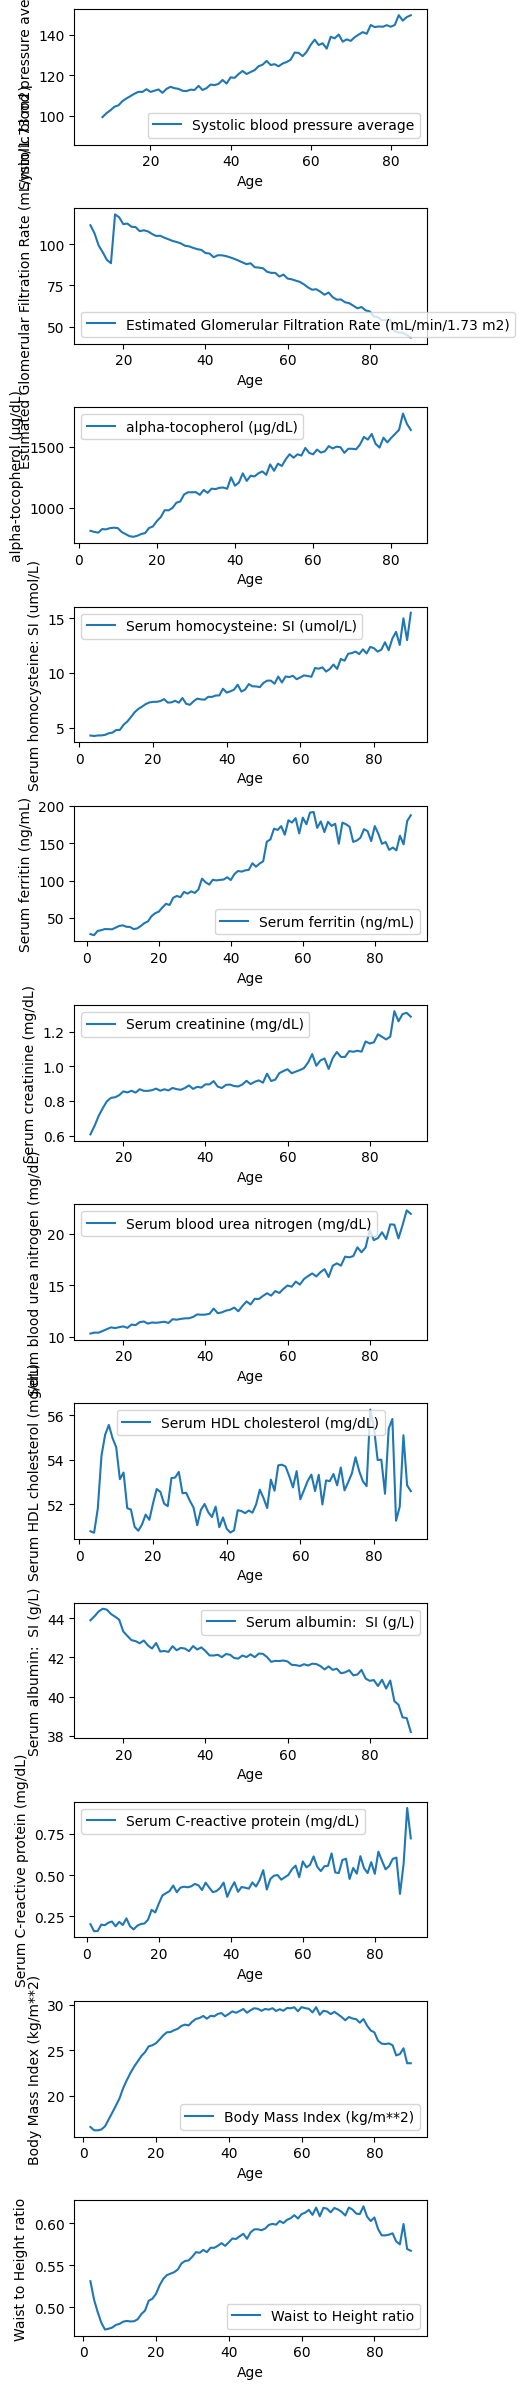

In [19]:
grouped_df = df.groupby('age')[features].mean()

# Plot each feature against age independently
fig, axs = plt.subplots(len(features), 1, figsize=(5, 2*len(features)))  # Adjust the figure size as necessary

for i, feature in enumerate(features):
    axs[i].plot(grouped_df.index, grouped_df[feature], label=feature)
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel(feature)
    axs[i].legend()

plt.tight_layout()
plt.show()

In [22]:

# cat_features = demographics_list1_updated[demographics_list1_updated.data_type == 'categorical']['variable_codename_use'].to_numpy()  # Выделяем категориальные признаки
cat_features = []
targets = ["age"]
features2drop = ['SEQN', 'SEQN_new']  # эти фичи будут удалены

X = df[features].drop(targets, axis=1, errors="ignore")
y = df[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('y_train.mean()', y_train.mean(), 'y_test.mean()', y_test.mean())

rg = CatBoostRegressor(random_seed=42, custom_metric=['RMSE', 'MAE', 'R2'], max_depth=7, iterations=700)#, **params)

rg.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=False,
    use_best_model=True,
    plot=True,
    early_stopping_rounds=100,
)

rg.get_feature_importance(prettified=True).head(50)

y_train.mean() age    32.119605
dtype: float64 y_test.mean() age    32.359604
dtype: float64


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,Estimated Glomerular Filtration Rate (mL/min/1...,25.974828
1,Body Mass Index (kg/m**2),12.692462
2,Serum blood urea nitrogen (mg/dL),12.515302
3,Waist to Height ratio,11.975451
4,Serum creatinine (mg/dL),11.433886
5,Serum ferritin (ng/mL),7.269570
6,alpha-tocopherol (µg/dL),5.145383
7,Serum albumin: SI (g/L),5.034234
8,Serum HDL cholesterol (mg/dL),2.998002
9,Serum homocysteine: SI (umol/L),2.207478


In [ ]:
20 - 30 = -10
# Mean Average Error
# MAE / age


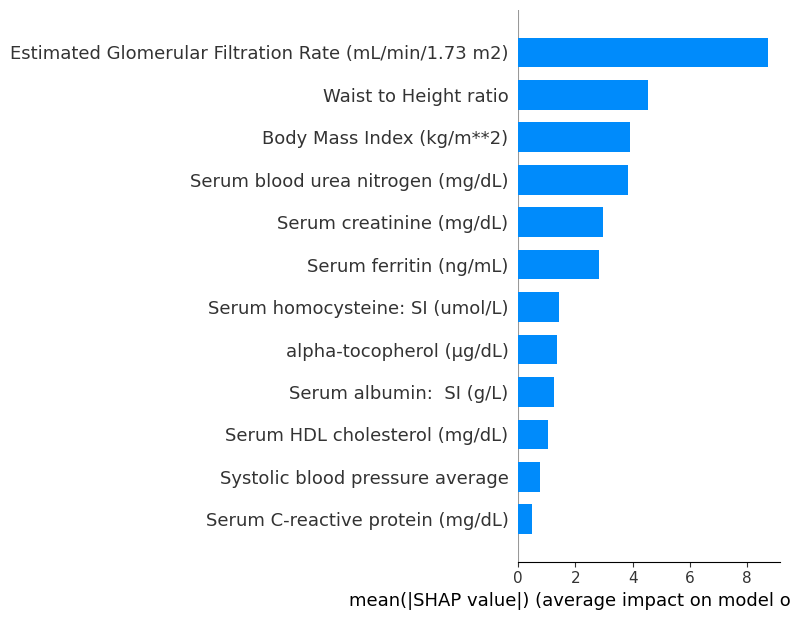

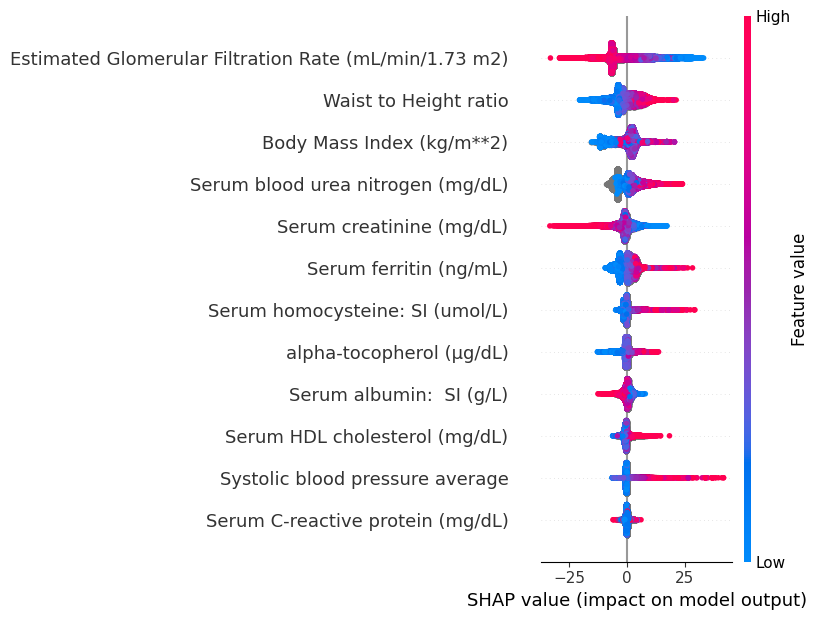

In [23]:
import shap  # Ensure you have SHAP installed

# Train your model (CatBoostRegressor) as you have described in your question

# Create a SHAP explainer object using your trained model
# Note: For CatBoost, use the model directly without wrapping it in a Pool object
explainer = shap.Explainer(rg)

# Calculate SHAP values for all the data
# Depending on your dataset size, this operation can be resource-intensive
shap_values = explainer(X)

# Summary plot for all data
shap.summary_plot(shap_values, X, plot_type="bar")

# This will display a bar chart showing the average impact of each feature on model output magnitude.
# The features are ranked by their importance.

# Additionally, to see how each feature value affects the predictions, you can use:
shap.summary_plot(shap_values, X)

# This plot shows the SHAP values on a color scale, indicating how high or low feature values
# influence the prediction outcome across all the data points.


In [24]:
# Optionally, calculate and interpret SHAP values for a deeper understanding
import shap  # Ensure SHAP is installed
explainer = shap.TreeExplainer(rg)
shap_values = explainer.shap_values(Pool(X_test, label=y_test, cat_features=cat_features))

# Visualize the SHAP values for the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])


In [25]:
df[features].isna().sum()

Systolic blood pressure average                          106693
Estimated Glomerular Filtration Rate (mL/min/1.73 m2)     39058
alpha-tocopherol (µg/dL)                                  84792
Serum homocysteine: SI (umol/L)                           84601
Serum ferritin (ng/mL)                                    57949
Serum creatinine (mg/dL)                                  38971
Serum blood urea nitrogen (mg/dL)                         38974
Serum HDL cholesterol (mg/dL)                             23582
Serum albumin:  SI (g/L)                                  38966
Serum C-reactive protein (mg/dL)                          51762
Body Mass Index (kg/m**2)                                  6116
Waist to Height ratio                                     10965
dtype: int64

In [9]:
meta_features = ['gender', 'age', 'SEQN', 'SEQN_new']
df[features + meta_features].to_csv('train_data.csv')

In [10]:
features

['Waist Circumference (cm)',
 'Standing Height (cm)',
 'Weight (kg)',
 'Systolic blood pressure average',
 'Estimated Glomerular Filtration Rate (mL/min/1.73 m2)',
 'alpha-tocopherol (µg/dL)',
 'Serum homocysteine: SI (umol/L)',
 'Serum ferritin (ng/mL)',
 'Serum creatinine (mg/dL)',
 'Serum blood urea nitrogen (mg/dL)',
 'Serum HDL cholesterol (mg/dL)',
 'Serum albumin:  SI (g/L)',
 'Serum C-reactive protein (mg/dL)',
 'Body Mass Index (kg/m**2)',
 'Waist to Height ratio']

# playground

<Axes: xlabel='age'>

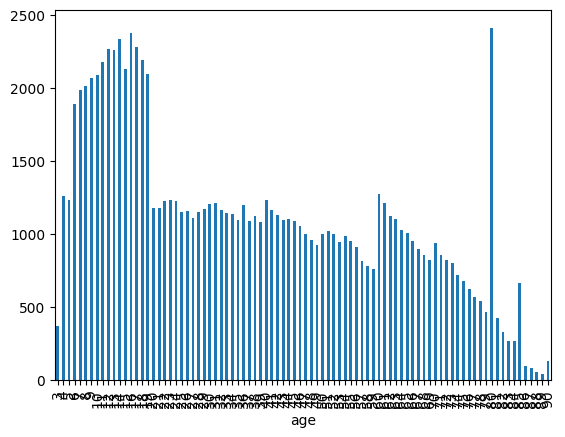

In [26]:
q = df[['Serum HDL cholesterol:  SI (mmol/L)', 'age']].dropna()
q['age'].value_counts().sort_index().plot(kind='bar')

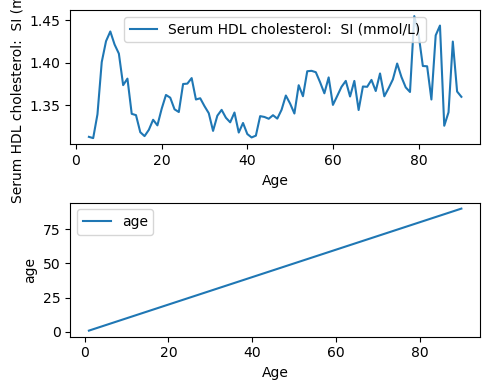

In [26]:
features = ['Serum HDL cholesterol:  SI (mmol/L)', 'age']
grouped_df = df.groupby('age')[features].mean()

# Plot each feature against age independently
fig, axs = plt.subplots(len(features), 1, figsize=(5, 2*len(features)))  # Adjust the figure size as necessary

for i, feature in enumerate(features):
    axs[i].plot(grouped_df.index, grouped_df[feature], label=feature)
    axs[i].set_xlabel('Age')
    axs[i].set_ylabel(feature)
    axs[i].legend()

plt.tight_layout()
plt.show()



In [92]:
# dem = pd.read_csv('../data/nhanes_1994-2018/demographics_clean.csv', index_col=0)
# dem

,SEQN,SEQN_new,AIALANGA,DMAETHN,DMAETHNR,DMARACE,DMARACER,DMDBORN4,DMDCITZN,DMDEDUC,...,WTMREP43,WTMREP44,WTMREP45,WTMREP46,WTMREP47,WTMREP48,WTMREP49,WTMREP50,WTMREP51,WTMREP52
1,3.0,I-3,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,I-4,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,I-9,NaN,NaN,3.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10.0,I-10,NaN,NaN,3.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11.0,I-11,NaN,NaN,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135306,102952.0,C-102952,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135307,102953.0,C-102953,2.0,NaN,NaN,NaN,NaN,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135308,102954.0,C-102954,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135309,102955.0,C-102955,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
# chem = pd.read_csv('../data/nhanes_1994-2018/chemicals_clean.csv', index_col=0)
response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


/var/folders/gm/xnklr9cn25d9zttg6821cbrw0000gp/T/ipykernel_26172/1663938094.py:2: DtypeWarning: Columns (828,829,836,837,846,847,947,948,980,981) have mixed types. Specify dtype option on import or set low_memory=False.
  response = pd.read_csv('../data/nhanes_1994-2018/response_clean.csv', index_col=0)


In [97]:
dictionary_nhanes = pd.read_csv('../data/nhanes_1994-2018/dictionary_nhanes.csv',index_col=0)
dictionary_nhanes

,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten
1,SEQN,Respondent sequence number,Mortality,Survey Variables,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
2,SEQN_new,Respondent sequence number that includes an id...,Mortality,Survey Variables,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
3,ELIGSTAT,Eligibility Status for Mortality Follow-up,Mortality,Mortality,135310,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
4,MORTSTAT,Final Mortality Status,Mortality,Mortality,78663,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
5,UCOD_LEADING,Underlying Cause of Death Recode from UCOD_113...,Mortality,Mortality,17857,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5369,URDPMMLC,Comments code for N-acetyl-s-(3-hydroxypropyl-...,Comments,Volatile Organic Compound (VOC) Metabolites,11243,"2005-2006, 2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN
5370,URDTCVLC,Comments code for N-acetyl-s-(trichlorovinyl)-...,Comments,Volatile Organic Compound (VOC) Metabolites,11269,"2005-2006, 2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN
5371,URDTTCLC,Comments code for 2-thioxothiazolidine-4-carbo...,Comments,Volatile Organic Compound (VOC) Metabolites,8275,"2005-2006, 2011-2012, 2013-2014",NaN,NaN,NaN,NaN,NaN
5372,LBXSZNLC,Comments code for Serum Zinc,Comments,Zinc,7284,"2011-2012, 2013-2014, 2015-2016",NaN,NaN,NaN,NaN,NaN


In [237]:
dictionary_nhanes[dictionary_nhanes['variable_description_use'].astype(str).str.contains('ystolic')]#[['variable_codename_use', 'variable_description_use']].values


,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten
963,BPXSAR,Systolic blood pressure average,Response,Blood Pressure,15052,"1999-2000, 2001-2002",NaN,NaN,NaN,NaN,NaN
964,BPXSY1,Systolic: Blood pressure (first reading) mm Hg,Response,Blood Pressure,91754,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
965,BPXSY11,Systolic: Blood pressure (first reading) repli...,Response,Blood Pressure,23100,1988-1994,NaN,NaN,NaN,NaN,NaN
966,BPXSY12,Systolic: Blood pressure (first reading) repli...,Response,Blood Pressure,1646,1988-1994,NaN,NaN,NaN,NaN,NaN
967,BPXSY2,Systolic: Blood pressure (second reading) mm Hg,Response,Blood Pressure,91099,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
968,BPXSY21,Systolic: Blood pressure (second reading) repl...,Response,Blood Pressure,23087,1988-1994,NaN,NaN,NaN,NaN,NaN
969,BPXSY22,Systolic: Blood pressure (second reading) repl...,Response,Blood Pressure,1648,1988-1994,NaN,NaN,NaN,NaN,NaN
970,BPXSY3,Systolic: Blood pressure (third reading) mm Hg,Response,Blood Pressure,90395,"1988-1994, 1999-2000, 2001-2002, 2003-2004, 20...",NaN,NaN,NaN,NaN,NaN
971,BPXSY31,Systolic: Blood pressure (third reading) repli...,Response,Blood Pressure,22981,1988-1994,NaN,NaN,NaN,NaN,NaN
972,BPXSY32,Systolic: Blood pressure (third reading) repli...,Response,Blood Pressure,1646,1988-1994,NaN,NaN,NaN,NaN,NaN


In [214]:
dictionary_nhanes[dictionary_nhanes['variable_description_use']=='Serum creatinine']

,variable_codename_use,variable_description_use,in_dataset,file_category,num_participants_measurements,unique_cycles,units,cas_num,comment_codename_use,chemical_family,chemical_family_shorten


In [133]:
dictionary_nhanes['in_dataset'].value_counts()

in_dataset
Questionnaire    1445
Response         1029
Weights           965
Chemicals         599
Comments          505
Demographics      389
Dietary           324
Occupation         73
Medications        29
Mortality          15
Name: count, dtype: int64

In [152]:
response.columns.value_counts()

Has a doctor or other health professional ever told {you/SP}that {you/he/she} had . . .    5
Serum triglycerides (mg/dL)                                                                2
Serum total cholesterol replicate 1 (mg/dL)                                                2
Serum total cholesterol (mg/dL)                                                            2
Serum triglycerides:  SI replicate 2 (mmol/L)                                              2
                                                                                          ..
Waist to hip ratio replicate 1                                                             1
Waist to hip ratio replicate 2                                                             1
Wrist breadth (cm) (2 years and over)                                                      1
Wrist breadth replicate 1 (cm) (2 years and over)                                          1
N-telopeptides (NTx) replicate 2 (nmol BCE)                           

In [159]:
dictionary_nhanes['file_category'].value_counts()[:20]

file_category
Survey Weights - Chemicals                     595
Medical Conditions                             573
Demographics                                   388
Survey Weights                                 370
Vitamin, Mineral, and Medicine Usage           192
Dioxins, Furans, & Coplanar PCBs               175
Volatile Organic Compound (VOC) Metabolites    168
Total Nutrient Intakes                         164
Reproductive Health                            156
Complete Blood Count                           150
Body Measures                                  127
Bioelectrical Impedance Analysis               124
Physical Activity                              113
Spirometry                                     103
Diabetes                                        86
Food Frequency                                  81
Vitamin A, Vitamin E & Carotenoids              76
Blood Pressure                                  75
Occupation                                      70
Fish & Shellfish 